# Удержиние активности постоянных клиентов интернет-магазин «В один клик»

Ссылка на репозиторий: https://github.com/9yx/practicum

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.


Вам нужно выполнить следующие задачи:
- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

Нам необходимо выполнить:
- открыть файлы с данными;
- выполнить предобработку данных:
    - изменить типы данных там где это необходимо;
    - проверить и устранить дубликаты;
    - проверить наличие пропущенных значений;  
- провести исследовательский анализ данных:
    - найти аномальные и выдающиеся значения;
    - выбрать данные для обучения.
- провести объединение таблиц;
- выполнить корреляционный анализ;
- используя пайплайны постоить лучшую модель для предсказания снижения покупательской активности;
- выполнить анализ важности признаков;
- выделить сегмент и разработать для него персонализированные предложения.

Установим необходимые пакеты:

In [1]:
# установим shap
!pip install shap
# обновим scikit-learn чтобы появился get_feature_names_out (в shap отобразились имена признаков)
!pip install -U scikit-learn
!pip install phik

Импортируем необходимые библиотеки:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import phik

from scipy import stats
from phik.report import plot_correlation_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    RandomizedSearchCV
)

## Загрузка данных

Откроем файл `market_file.csv` он содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:

In [3]:
market_file_df = pd.read_csv('/datasets/market_file.csv', sep=',', decimal='.')
market_file_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Посмотрим на общию информацию о таблице:

In [4]:
market_file_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Откроем файл `market_money.csv` он содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом:

In [5]:
market_money_df = pd.read_csv('/datasets/market_money.csv', sep=',', decimal='.')
market_money_df.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Посмотрим на общию информацию о таблице:

In [6]:
market_money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Откроем файл `market_time.csv` он содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода:

In [7]:
market_time_df = pd.read_csv('/datasets/market_time.csv', sep=',', decimal='.')
market_time_df.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Посмотрим на общию информацию о таблице:

In [8]:
market_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Откроем файл `money.csv` он содержит данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю:

In [9]:
money_df = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
money_df.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Посмотрим на общию информацию о таблице:

In [10]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Загрузили необходимые таблицы, данные в таблицах соответствуют описанию. Выполним предобработку данных. Необходимо проверить таблицы на дубликаты, пропуски. Проведем предобработку данных.

##  Предобработка данных

Проверим данные на наличие дубликатов. Создадим дополнительные функции для проверки на дубликаты:

In [11]:
def check_unique(df):
    """Выводит на экран список уникальных значений в сторокой колонке

    Args:
        df: датафрейм в котором берутся колонки
    Returns:
        Ничего.
    """
    # проверка на неявные дубликаты в строковых переменных
    for column in df.select_dtypes(include='object').columns.tolist():
        print(f"Колонка \"{column}\":")
        print(df[column].value_counts(), "\n")


def check_duplicated(df):
    """Проверяет на дубликаты датафрейм в случаи отсутствия выводит строку Дубликаты отсутсвуют.

    Args:
        df: датафрейм в котором проходит проверка
    Returns:
        Ничего.
    """
    # проверка на дубликаты
    dupl = df.duplicated().sum()
    print("Количество дубликатов:", dupl)
    if dupl > 0:
        display(df[df.duplicated()])
    else:
        print("Дубликаты отсутсвуют.")

### Таблица market_file

Проверим колонки на неявные дубликаты:

In [13]:
check_unique(market_file_df)

Колонка "Покупательская активность":
Прежний уровень    802
Снизилась          498
Name: Покупательская активность, dtype: int64 

Колонка "Тип сервиса":
стандарт     914
премиум      376
стандартт     10
Name: Тип сервиса, dtype: int64 

Колонка "Разрешить сообщать":
да     962
нет    338
Name: Разрешить сообщать, dtype: int64 

Колонка "Популярная_категория":
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64 


В колонке `Тип сервиса` есть неявный дубликат `стандарт` и `стандартт` исправим это:

In [14]:
market_file_df['Тип сервиса'] = market_file_df['Тип сервиса'].replace('стандартт', 'стандарт')
market_file_df['Тип сервиса'].value_counts()

стандарт    924
премиум     376
Name: Тип сервиса, dtype: int64

Проверим на дубликаты:

In [15]:
check_duplicated(market_file_df)

Количество дубликатов: 0
Дубликаты отсутсвуют.


### Таблица market_money

Проверим колонки на неявные дубликаты:

In [16]:
check_unique(market_money_df)

Колонка "Период":
текущий_месяц          1300
препредыдущий_месяц    1300
предыдущий_месяц       1300
Name: Период, dtype: int64 


Неявные дубликаты отсутствуют.

In [17]:
check_duplicated(market_money_df)

Количество дубликатов: 0
Дубликаты отсутсвуют.


### Таблица market_time

Проверим колонки на неявные дубликаты:

In [18]:
check_unique(market_time_df)

Колонка "Период":
текущий_месяц       1300
предыдцщий_месяц    1300
Name: Период, dtype: int64 


Изменим значение `предыдцщий_месяц` на `предыдущий_месяц`:

In [19]:
market_time_df['Период'] = market_time_df['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time_df['Период'].value_counts()

текущий_месяц       1300
предыдущий_месяц    1300
Name: Период, dtype: int64

Проверим на дубликаты:

In [20]:
check_duplicated(market_time_df)

Количество дубликатов: 0
Дубликаты отсутсвуют.


### Таблица money

Проверим колонки на неявные дубликаты:

In [21]:
check_unique(money_df)

Неявные дубликаты отсутствуют. Проверим на дубликаты:

In [22]:
check_duplicated(money_df)

Количество дубликатов: 0
Дубликаты отсутсвуют.


### Пропущенные значения

Пропущенные значения отсутствуют.

### Изменение типов данных

Типы данных у признаков корректные, изменение не требуются.

В процессе предобработки данных были убраны дубликаты, проверено остутствие пропущенных значений и необходимость изменения типов данных.

## Исследовательский анализ данных

Создадим дополнительные функции для анализа:

In [23]:
def column_quantitative_info(df, column):
    # для количественного признака
    desc = df[column].describe()
    print(desc)
    
        
    if df[column].dtype == 'int64':
        n_bins = (df[column].max() - df[column].min()) + 1
        if n_bins > 100:
            binwidth=None
            discrete = False
            bins='auto'
        else:
            bins=n_bins
            discrete = True
            binwidth = 1
    else:
        binwidth=None
        discrete = False
        bins='auto'
    
    print(discrete, bins)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    sns.histplot(data=df[column], kde=False, ax=axes[0], discrete=discrete, binwidth=binwidth, bins=bins)
    axes[0].axvline(df[column].mean(), color='red', linestyle='--', label='Mean')
    axes[0].set_title('Гистограмма распределения')
    axes[0].set_ylabel('Частота')
    axes[0].set_xlabel(column)
    sns.boxplot(data=df[column], palette='rainbow', ax=axes[1])
    axes[1].set_title('Разброс значений признаков')
    axes[1].set_ylabel('Значение')
    stats.probplot(df[column], plot=sns.mpl.pyplot, dist="norm")
    axes[2].set_title('Q-Q график')
    axes[2].set_ylabel('Квантили эмпирических данных')
    axes[2].set_xlabel('Теоретические квантили')
    plt.show()

def quantitative_info(df):
    # для количественного признака
    for column in df.loc[:, df.columns !='id'].select_dtypes(include='number').columns.tolist():
        print(f'Колонка: \'{column}\':')
        column_quantitative_info(df, column)
    
def categorical_info(df):
    # для категориального признака
    for column in df.loc[:, df.columns !='id'].select_dtypes(include='object').columns.tolist():
        print(f'Колонка: \'{column}\':')
        print((df[column].describe()))
        df[column].value_counts().plot(title=column, autopct='%1.1f%%', kind='pie', figsize=(7,7))
        plt.ylabel(f"Соотношение {column}")
        plt.show()

### Таблица market_file

Проанализируем количественные колонки:

Колонка: 'Маркет_актив_6_мес':
count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64
False auto


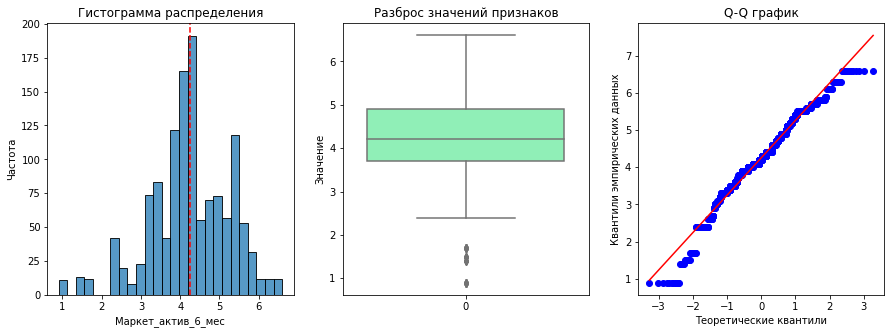

Колонка: 'Маркет_актив_тек_мес':
count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Маркет_актив_тек_мес, dtype: float64
True 3


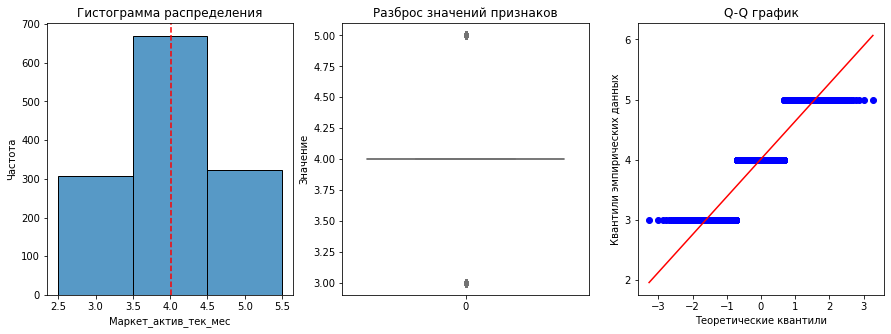

Колонка: 'Длительность':
count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64
False auto


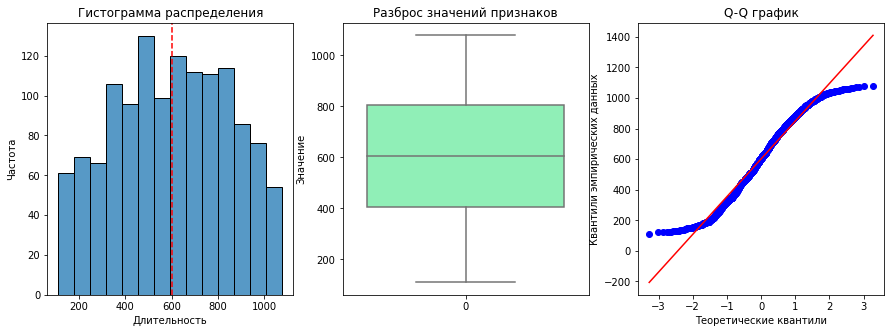

Колонка: 'Акционные_покупки':
count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64
False auto


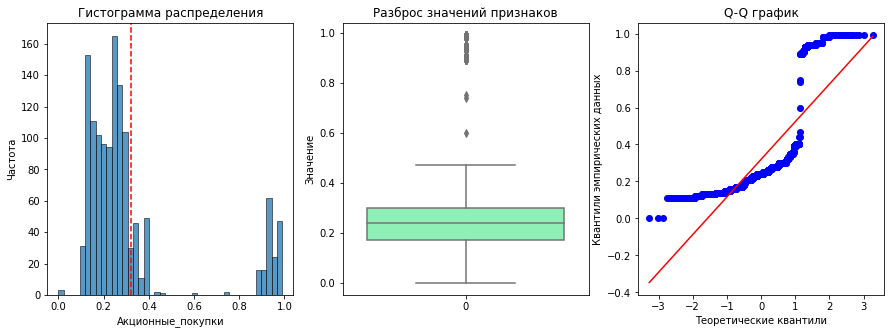

Колонка: 'Средний_просмотр_категорий_за_визит':
count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: Средний_просмотр_категорий_за_визит, dtype: float64
True 6


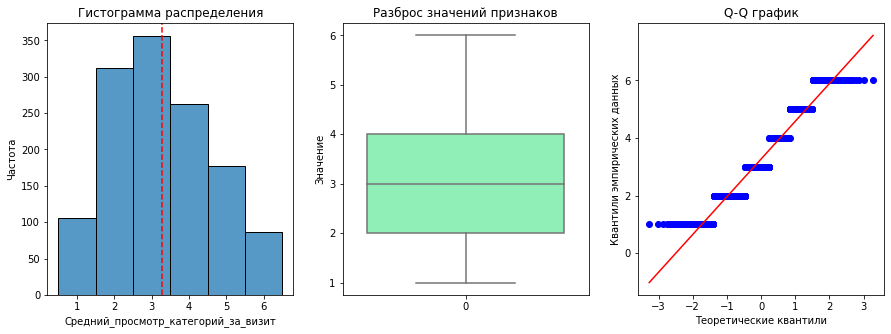

Колонка: 'Неоплаченные_продукты_штук_квартал':
count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64
True 11


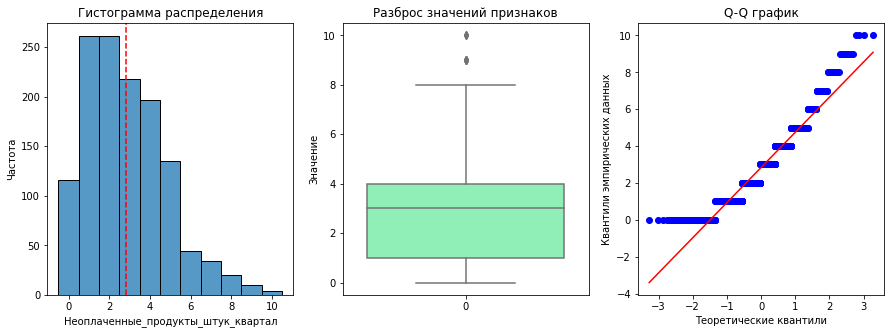

Колонка: 'Ошибка_сервиса':
count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Ошибка_сервиса, dtype: float64
True 10


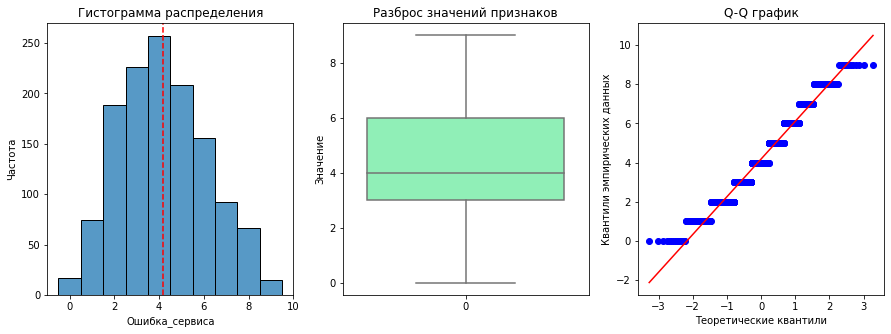

Колонка: 'Страниц_за_визит':
count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц_за_визит, dtype: float64
True 20


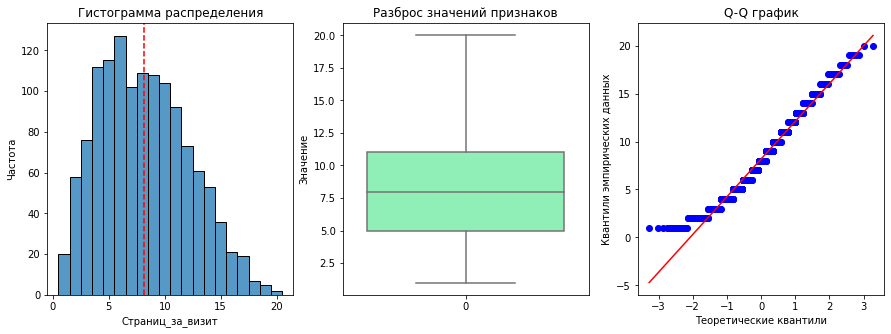

In [24]:
quantitative_info(market_file_df)

Признаки с нормальным распределением:
- Маркет_актив_6_мес
- Маркет_актив_тек_мес
- Длительность
- Средний_просмотр_категорий_за_визит
- Неоплаченные_продукты_штук_квартал
- Ошибка_сервиса
- Страниц_за_визит

C бимодальным распределением:
- Акционные_покупки

В данных отсутствуют аномальные значения и выбросы. Выводы:

- среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние `6` месяцев равно `4,2`
- среднее значение количество маркетинговых коммуникаций в текущем месяце равно `4`
- самый старый пользователь быль зарегистрирован `1079` дней назад
- среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев равно `0.32%`
- пользователи в среднем просматривают `3` категории и `10` страниц.

Проанализируем категориальные колонки:

Колонка: 'Покупательская активность':
count                1300
unique                  2
top       Прежний уровень
freq                  802
Name: Покупательская активность, dtype: object


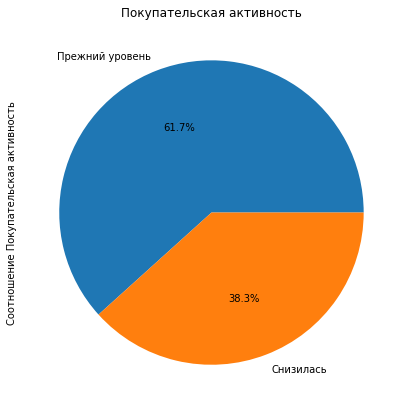

Колонка: 'Тип сервиса':
count         1300
unique           2
top       стандарт
freq           924
Name: Тип сервиса, dtype: object


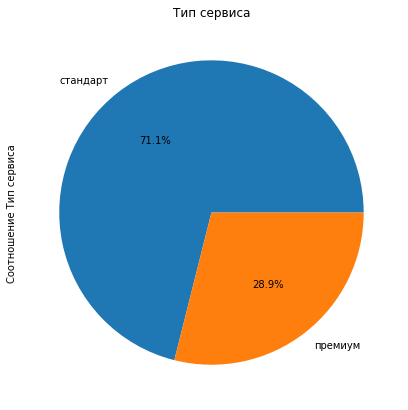

Колонка: 'Разрешить сообщать':
count     1300
unique       2
top         да
freq       962
Name: Разрешить сообщать, dtype: object


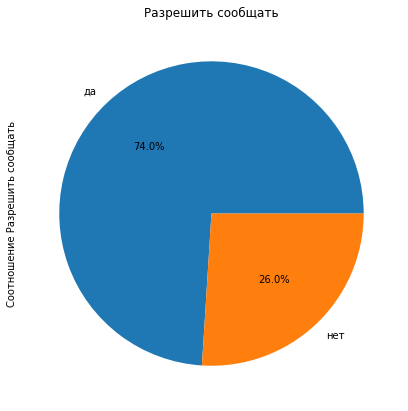

Колонка: 'Популярная_категория':
count                 1300
unique                   6
top       Товары для детей
freq                   330
Name: Популярная_категория, dtype: object


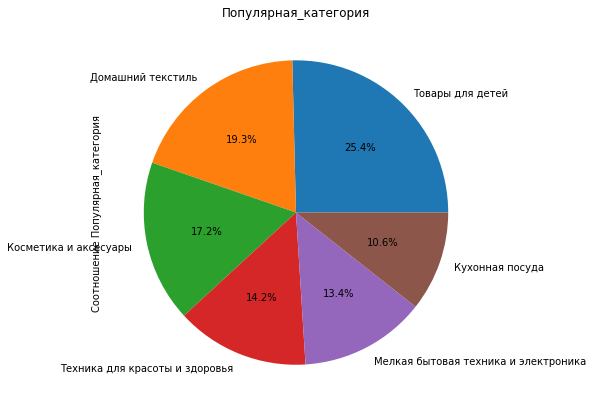

In [25]:
categorical_info(market_file_df)

Выводы:
- у большенства пользователей покупательская активность сохранилась (`61.7%`)
- у большенства стандартный уровень сервиса (`71.1%`)
- большество разрешило присылать дополнительные предложения о товаре (`74%`)
- наиболее популярная категория `Товары для детей` наименее `Кухонная посуда`
- в данных в целевой колонке `Покупательская активность` несбалансированы с прежним уровнем больше чем снизившимся.

### Таблица market_money

Проанализируем количественные колонки:

Колонка: 'Выручка':
count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64
False auto


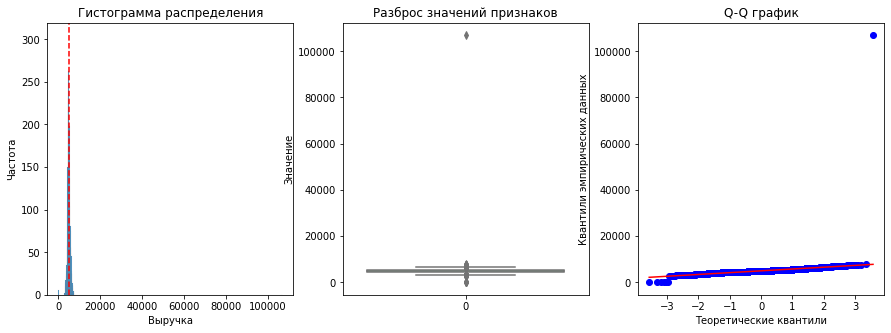

In [26]:
quantitative_info(market_money_df)

Найдем покупателя который потратил более `100000` это выброс:

In [27]:
market_money_df[market_money_df['Выручка']>100000]

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


Выведем информацию из `market_file_df` о покупателе:

In [28]:
market_file_df[market_file_df['id'].isin(pd.Series([215380]))]

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


Заменим значение выручки на моду:

count    3900.000000
mean     4999.508051
std       706.922488
min         0.000000
25%      4590.150000
50%      4956.500000
75%      5363.000000
max      7799.400000
Name: Выручка, dtype: float64
False auto


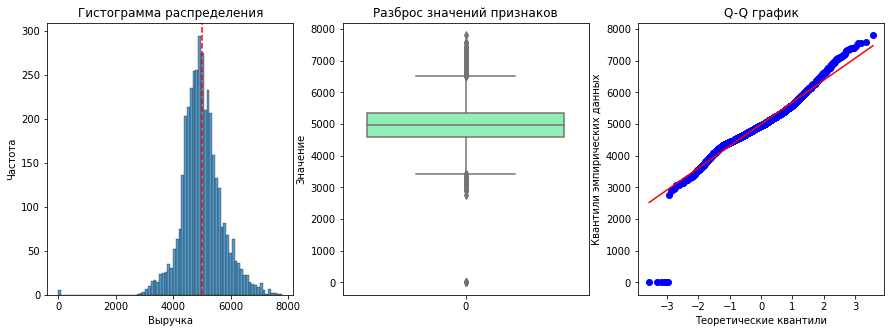

In [29]:
market_money_df.loc[market_money_df['Выручка']>100000, 'Выручка'] = market_money_df['Выручка'].mode()[0]
column_quantitative_info(market_money_df, 'Выручка')

Средняя выручка за месяц равно `5000` у признака нормальное распределение.

Проанализируем категориальные колонки:

Колонка: 'Период':
count              3900
unique                3
top       текущий_месяц
freq               1300
Name: Период, dtype: object


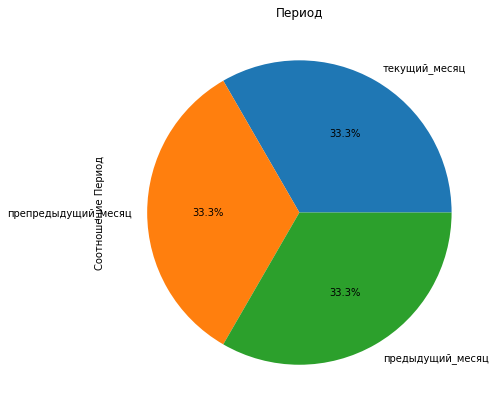

In [30]:
categorical_info(market_money_df)

Данные по месяцам распредленны равномерно.

### Таблица market_time

Проанализируем количественные колонки:

Колонка: 'минут':
count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64
True 20


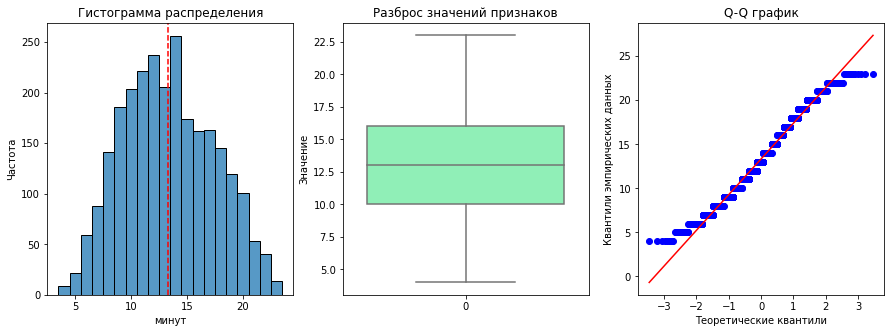

In [31]:
quantitative_info(market_time_df)

В данных отсутствуют аномальные значения и выбросы. Покупатели проводят от `4` до `23` минут на сайте. У признака `минут` нормальное распределение.

Проанализируем категориальные колонки:

Колонка: 'Период':
count              2600
unique                2
top       текущий_месяц
freq               1300
Name: Период, dtype: object


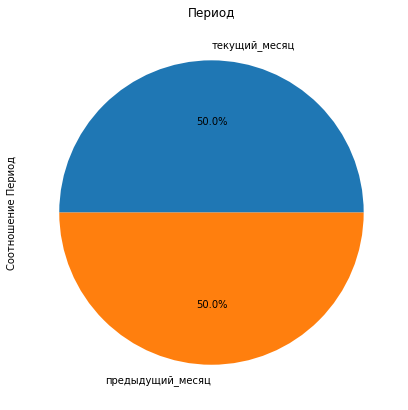

In [32]:
categorical_info(market_time_df)

В данных отсутвует информация за препредыдущий месяц.

### Таблица money

Проанализируем количественные колонки:

Колонка: 'Прибыль':
count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64
False auto


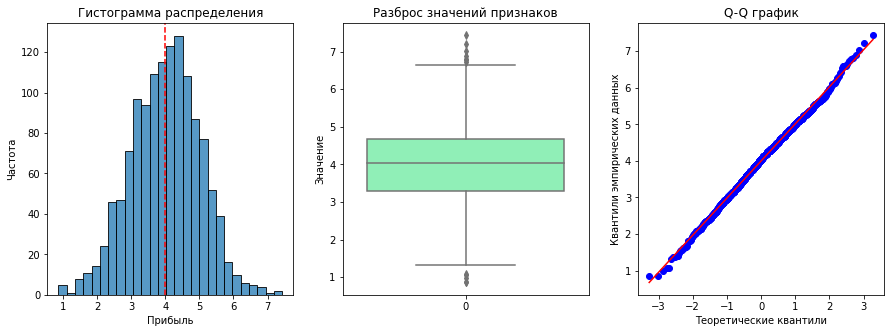

In [33]:
quantitative_info(money_df)

Средняя среднемесячная прибыли покупателя за последние `3` месяца равна `4`. Нормальное распределение.

### Клиенты с покупательской активностью не менее 3 месяцев

Отберим клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период:

In [34]:
market_active_df = market_money_df.copy()
market_active_df.loc[market_active_df['Выручка'] > 0, 'Выручка'] = 1
active_clients_id = market_active_df.groupby('id')['Выручка'].sum().reset_index()
active_clients_id = active_clients_id[active_clients_id['Выручка'] == 3]['id']
market_active_df = market_file_df[market_file_df['id'].isin(active_clients_id)]
market_active_df

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7


1297 из 1300 совершали покупки в каждом из 3 месяцев. Выведем пользователей которые не совершали покупки в течении 3 месяцев:

In [35]:
market_file_df[~market_file_df['id'].isin(active_clients_id)]

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
9,215357,Снизилась,стандарт,да,3.9,5,154,0.0,Техника для красоты и здоровья,3,3,9,5
11,215359,Снизилась,стандарт,да,4.6,5,110,0.0,Домашний текстиль,4,2,4,2


Почти у всех пользователей покупательская активность не менее 3 месяцев.

Проведен иследовательский анализ, проверино наличие выбросов и аномалий в данных, удалены выбросы в данных, выбраны постоянные клиенты которые имеют активность не менее 3 месяцев.

## Объединение таблиц

Объединим данные таблиц используя клиентов с покупательской активностью не менее трёх месяцев:

In [36]:
def value_money(row, value):
    value = market_money_df[(market_money_df['id']==row['id']) & (market_money_df['Период']==value)]['Выручка']
    if len(value)>0:
        return value.iloc[0]
    else:
        return 0.0

def value_time(row, value):
    value = market_time_df[(market_time_df['id']==row['id']) & (market_time_df['Период']==value)]['минут']
    if len(value)>0:
        return value.iloc[0]
    else:
        return 0.0

# отключил варнинг так не нашел способа исправить предупреждение   
pd.options.mode.chained_assignment = None
    
join_df=market_active_df
join_df.loc[:, 'Предыдущий_месяц_выручка'] = market_file_df.apply(value_money, args=('предыдущий_месяц',), axis=1)
join_df.loc[:, 'Текущий_месяц_выручка'] = market_file_df.apply(value_money, args=('текущий_месяц',), axis=1)
join_df.loc[:, 'Препредыдущий_месяц_выручка'] = market_file_df.apply(value_money, args=('препредыдущий_месяц',), axis=1)

join_df.loc[:, 'Предыдущий_месяц_минут'] = market_file_df.apply(value_time, args=('предыдущий_месяц',), axis=1)
join_df.loc[:, 'Текущий_месяц_минут'] = market_file_df.apply(value_time, args=('текущий_месяц',), axis=1)
join_df

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Предыдущий_месяц_выручка,Текущий_месяц_выручка,Препредыдущий_месяц_выручка,Предыдущий_месяц_минут,Текущий_месяц_минут
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4971.6,4472.0,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,5058.4,4826.0,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,6610.4,4793.0,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,5872.5,4594.0,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5388.5,5124.0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4741.7,4704.0,14,7
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5353.0,5299.0,12,11
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5139.2,5334.0,12,18
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,5224.6,4725.0,18,7


Таблицы объеденены в одну таблицу, значения из столбца пересены в колонки.

## Корреляционный анализ

Рассчитаем коэффициенты корреляции между всеми признаками, проверим наличие мультиколлеарность признаков.

Для признаков с нормальным распределением будем использовать коэффициент Пирсона, для остальных Спирмена.

In [37]:
# с нормальным распределением
normal_distr_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 
                        'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал',
                        'Ошибка_сервиса', 'Страниц_за_визит', 'Предыдущий_месяц_выручка', 'Текущий_месяц_выручка',
                        'Препредыдущий_месяц_выручка', 'Предыдущий_месяц_минут', 'Текущий_месяц_минут']

# с другим
non_normal_column = 'Акционные_покупки'

<AxesSubplot:>

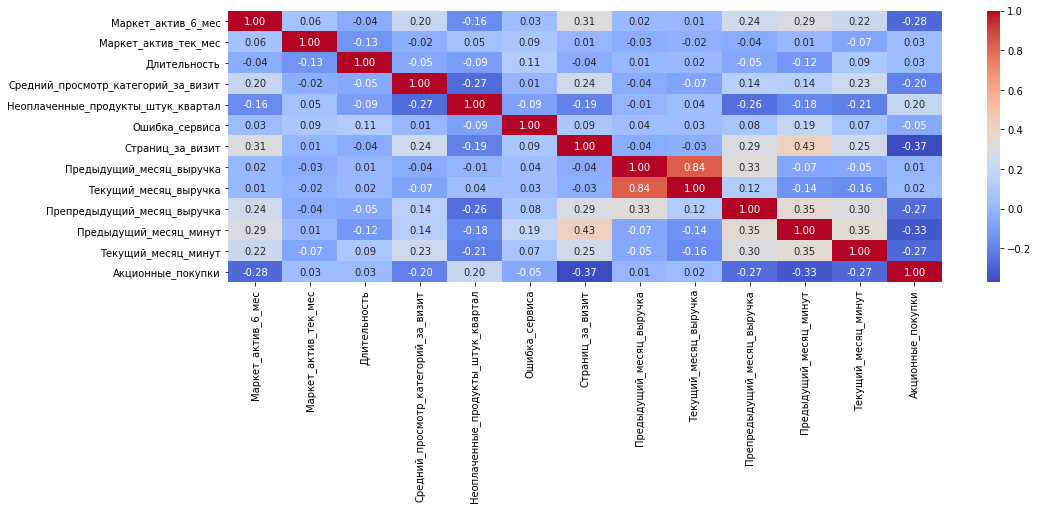

In [38]:
# коэффициент Пирсона:
corr_pirson_df = join_df.loc[:, join_df.columns.isin(normal_distr_columns)].corr()

# коэффициент Спирмена:
corr_spearman_df = (join_df.loc[:, join_df.columns !='id']
    .corrwith(join_df[non_normal_column], method='spearman').to_frame(name=non_normal_column))

corr = corr_pirson_df.join(corr_spearman_df)
corr = pd.concat([corr, corr_spearman_df.T], axis=0)

plt.figure(figsize=(16,5))
(sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f'))

Текущий месяц выручка и предыдущий месяц выручка имеют высокое значение корреляции `0,84` но у них отстутвует мультиколлеарность (от `0,9`). В остальных признаках значение корреляции не превышает `0.5`.

Построим матрицу корреляции между таргетом и признаками используя `phik`, так как таргет является категориальным признаком:

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Предыдущий_месяц_выручка', 'Текущий_месяц_выручка', 'Препредыдущий_месяц_выручка', 'Предыдущий_месяц_минут', 'Текущий_месяц_минут']


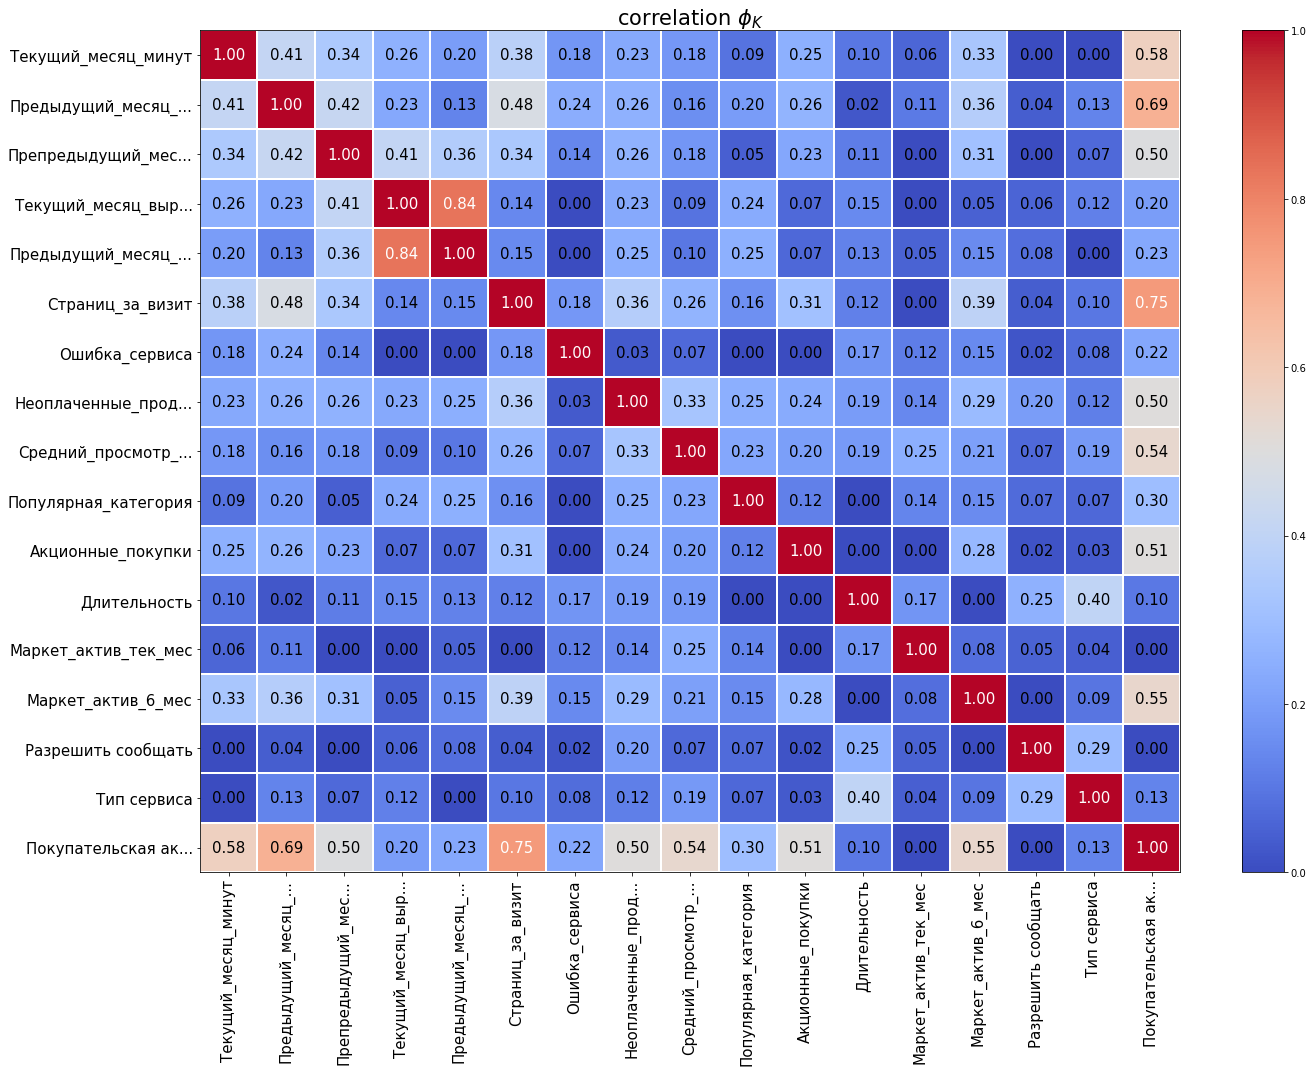

In [39]:
phik_overview = join_df.loc[:, join_df.columns !='id'].phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Найдем характеристику силу связи между признаками и таргетом:

In [40]:
def cheddar_scale(ser):
    for index in ser.index:
        corr = ser[index]
        if 0.1 <= corr <= 0.3:
            coupling_strength = f'слабая ({corr:.3f})'
        elif 0.3 < corr <= 0.5:
            coupling_strength = f'умеренная ({corr:.3f})'
        elif 0.5 < corr <= 0.7:
            coupling_strength = f'заметная ({corr:.3f})'
        elif 0.7 < corr <= 0.9:
            coupling_strength = f'высокая ({corr:.3f})'
        elif 0.9 < corr <= 1:
            coupling_strength = f'весьма высокая ({corr:.3f})'
        else:
            coupling_strength = f'отстутствует ({corr:.3f})'
        
        print(f'Сила связи между Покупательская активность и {index}: {coupling_strength}')
    

cheddar_scale(phik_overview['Покупательская активность'])

Сила связи между Покупательская активность и Покупательская активность: весьма высокая (1.000)
Сила связи между Покупательская активность и Тип сервиса: слабая (0.132)
Сила связи между Покупательская активность и Разрешить сообщать: отстутствует (0.000)
Сила связи между Покупательская активность и Маркет_актив_6_мес: заметная (0.546)
Сила связи между Покупательская активность и Маркет_актив_тек_мес: отстутствует (0.000)
Сила связи между Покупательская активность и Длительность: слабая (0.102)
Сила связи между Покупательская активность и Акционные_покупки: заметная (0.507)
Сила связи между Покупательская активность и Популярная_категория: слабая (0.298)
Сила связи между Покупательская активность и Средний_просмотр_категорий_за_визит: заметная (0.539)
Сила связи между Покупательская активность и Неоплаченные_продукты_штук_квартал: заметная (0.505)
Сила связи между Покупательская активность и Ошибка_сервиса: слабая (0.224)
Сила связи между Покупательская активность и Страниц_за_визит: выс

С сильной связью между признаками и таргетом:
- Страниц_за_визит

С средней:
- Маркет_актив_6_мес
- Акционные_покупки
- Средний_просмотр_категорий_за_визит
- Неоплаченные_продукты_штук_квартал
- Препредыдущий_месяц_выручка
- Предыдущий_месяц_минут
- Текущий_месяц_минут

## Использование пайплайнов

Используем пайплайны для нахождения лучшей модели. Для подбора параметров будем использовать метрику ROC-AUC. Она нечуствительна к дисбалансу классов, также будем использовать стратификацию.

Будем использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт лучшую модель:

In [41]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = join_df.drop(['id', 'Покупательская активность'], axis=1)
y = join_df['Покупательская активность']

# используем stratify, для сохранения пропорции
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

# создаём списки с названиями признаков
ohe_columns = ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 
               'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 
               'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 
               'Предыдущий_месяц_выручка', 'Текущий_месяц_выручка', 'Препредыдущий_месяц_выручка', 
               'Предыдущий_месяц_минут', 'Текущий_месяц_минут']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(3, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC() 
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__degree': range(2, 6),
        'models__kernel': ['poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:,1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('num', MinMaxScaler(),
                                                  ['Марке

Получена лучшая модель по метрике `ROC-AUC` это `LogisticRegression`.

## Анализ важности признаков

Оценим важность признаков для модели по величине коэффициентов:

In [42]:
model = randomized_search.best_estimator_.named_steps['models']
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
transformed = preprocessor.transform(X_test)

X_test_p = pd.DataFrame(
    transformed,
    columns=preprocessor.get_feature_names_out()
) 

Построим график важности признаков по величине коэффициентов:

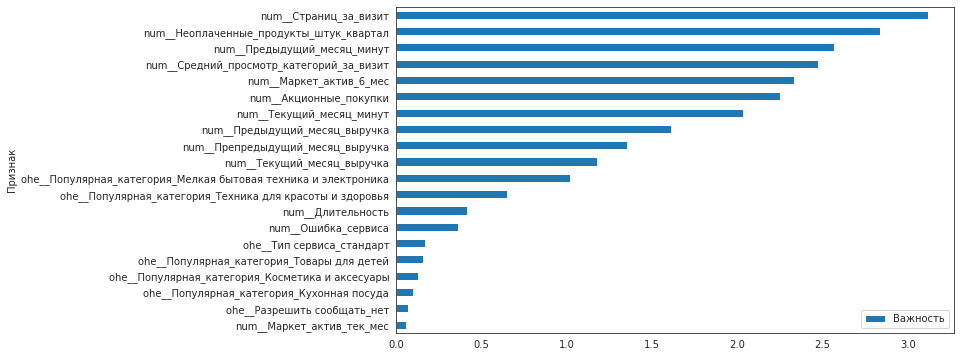

In [43]:
coefficients = model.coef_[0]
sns.set_style('white')
feature_importance = pd.DataFrame({'Признак': X_test_p.columns, 'Важность': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Важность', ascending=True)
feature_importance.plot(x='Признак', y='Важность', kind='barh', figsize=(10, 6)) 
plt.show()

Посторим график важности с помощью метода SHAP:

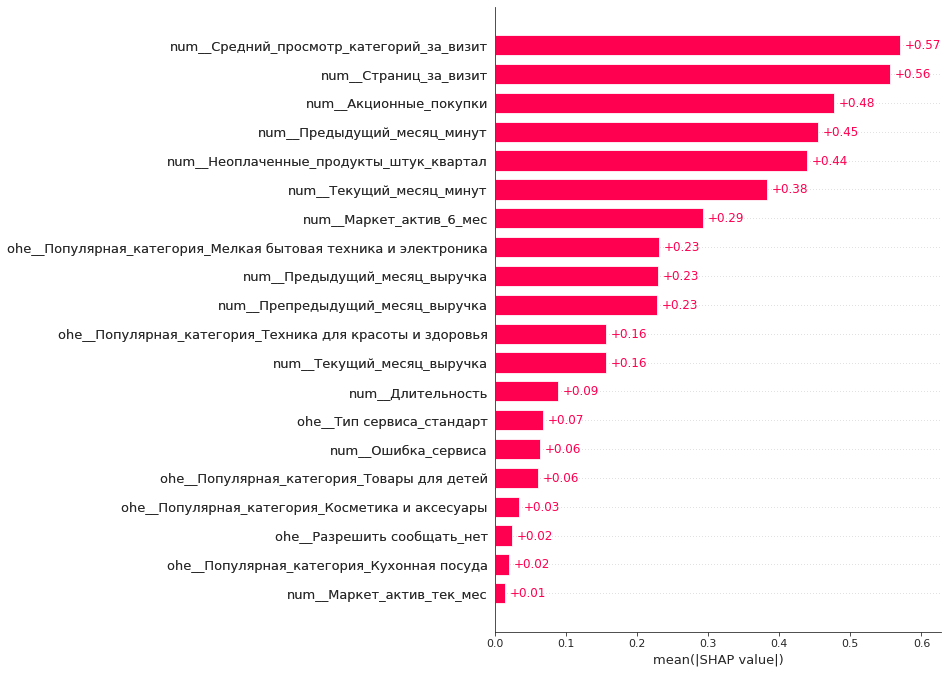

In [44]:
explainer = shap.LinearExplainer(model, X_test_p)
shap_values = explainer(transformed)
shap_values.feature_names = preprocessor.get_feature_names_out().tolist()
shap.plots.bar(shap_values, max_display=30)

Визуализацируем вклад признаков в каждое предсказание модели:

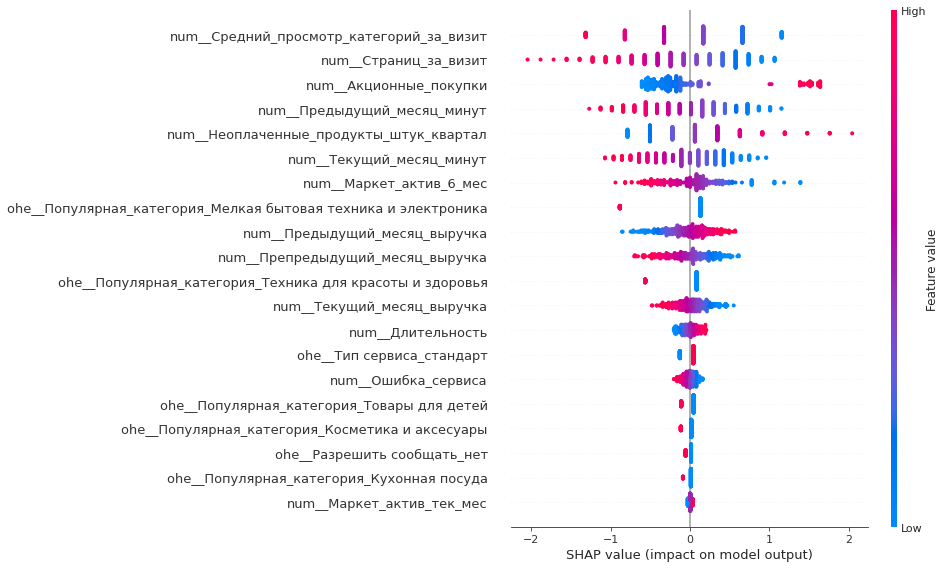

In [45]:
shap.plots.beeswarm(shap_values, max_display=30)

Мало значимые признаки по SHAP:
- Маркет актив тек мес
- Популярный категория Кухонная посуда
- Разрешить сообщать нет
- Популярная категория Косметика и аксесуары
- Популярная категория Товары для детей
- Ошибка сервиса
- Тип сервиса стандарт
- Длительность

Признаки сильнее всего влияющие на целевой признак:
- Средний просмотр категорий за визит
- Страниц за визит
- Аукционные покупки
- Предыдущий месяц минут
- Неоплаченные продукты штук квартал
- Текущий месяц минут
- Маркет актив 6 мес
- Популярная категория Мелкая бытовая техника и электроника
- Предыдущий месяц выручка
- Препредыдущий месяц выручка
- Популярная категория Техника для красоты и здоровья
- Текущий месяц выручка

Выделены признаки которые наиболее сильно влияют на целевой, также малозначимые. При моделировании малозначимые признаки можно использовать для уменьшения признакового описания, что может улучшить увеличить качество модели.
При принятии бизнес решений нужно учитывать признаки с сильным влиянием на целевой признак для получения нужного значения целевого признака. 

## Сегментация покупателей

Выдилим сегмент - Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

Выбирем клиентов с максимальной долей покупок по акции:

In [46]:
max_value = join_df['Акционные_покупки'].max()
segment_df =join_df.query('Акционные_покупки == @max_value')
segment_df

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Предыдущий_месяц_выручка,Текущий_месяц_выручка,Препредыдущий_месяц_выручка,Предыдущий_месяц_минут,Текущий_месяц_минут
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,6610.4,4793.0,11,13
40,215388,Снизилась,стандарт,да,3.5,4,663,0.99,Домашний текстиль,4,2,2,2,3188.0,3232.2,4182.0,10,12
97,215445,Снизилась,стандарт,нет,4.0,5,372,0.99,Косметика и аксесуары,1,6,6,5,5186.5,5208.6,4528.0,9,10
115,215463,Снизилась,стандарт,нет,3.1,4,472,0.99,Домашний текстиль,2,6,3,3,5196.0,5015.3,4470.0,8,12
135,215483,Снизилась,стандарт,да,3.9,5,855,0.99,Кухонная посуда,2,6,7,6,6349.0,6355.5,4834.0,8,8
137,215485,Снизилась,стандарт,да,3.5,4,720,0.99,Косметика и аксесуары,1,2,4,7,4201.0,5065.5,4234.0,10,14
145,215493,Снизилась,стандарт,да,4.0,5,881,0.99,Кухонная посуда,3,5,6,5,6716.5,7799.4,4870.0,9,10
189,215537,Снизилась,премиум,да,3.9,4,705,0.99,Косметика и аксесуары,3,3,7,4,6121.5,6781.9,4974.0,7,9
217,215565,Снизилась,стандарт,нет,2.4,4,522,0.99,Кухонная посуда,2,5,4,4,4657.0,5104.2,4492.0,11,12
225,215573,Снизилась,стандарт,да,4.1,4,706,0.99,Кухонная посуда,2,6,2,6,5418.0,5501.2,4671.0,12,12


Спрогнозируем покупательскую активность используя модель и выбирем с снижением покупательской активности:

In [47]:
segment_df.loc[:, 'Покупательская активность'] = randomized_search.predict(segment_df)
segment_df.loc[:, 'Покупательская активность вероятность'] = randomized_search.predict_proba(segment_df)[:,1]
segment_df.query('`Покупательская активность` == "Снизилась"')

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Предыдущий_месяц_выручка,Текущий_месяц_выручка,Препредыдущий_месяц_выручка,Предыдущий_месяц_минут,Текущий_месяц_минут,Покупательская активность вероятность
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,6610.4,4793.0,11,13,0.806432
40,215388,Снизилась,стандарт,да,3.5,4,663,0.99,Домашний текстиль,4,2,2,2,3188.0,3232.2,4182.0,10,12,0.961655
97,215445,Снизилась,стандарт,нет,4.0,5,372,0.99,Косметика и аксесуары,1,6,6,5,5186.5,5208.6,4528.0,9,10,0.993976
115,215463,Снизилась,стандарт,нет,3.1,4,472,0.99,Домашний текстиль,2,6,3,3,5196.0,5015.3,4470.0,8,12,0.996315
135,215483,Снизилась,стандарт,да,3.9,5,855,0.99,Кухонная посуда,2,6,7,6,6349.0,6355.5,4834.0,8,8,0.993690
137,215485,Снизилась,стандарт,да,3.5,4,720,0.99,Косметика и аксесуары,1,2,4,7,4201.0,5065.5,4234.0,10,14,0.968643
145,215493,Снизилась,стандарт,да,4.0,5,881,0.99,Кухонная посуда,3,5,6,5,6716.5,7799.4,4870.0,9,10,0.979810
189,215537,Снизилась,премиум,да,3.9,4,705,0.99,Косметика и аксесуары,3,3,7,4,6121.5,6781.9,4974.0,7,9,0.969811
217,215565,Снизилась,стандарт,нет,2.4,4,522,0.99,Кухонная посуда,2,5,4,4,4657.0,5104.2,4492.0,11,12,0.990342
225,215573,Снизилась,стандарт,да,4.1,4,706,0.99,Кухонная посуда,2,6,2,6,5418.0,5501.2,4671.0,12,12,0.982744


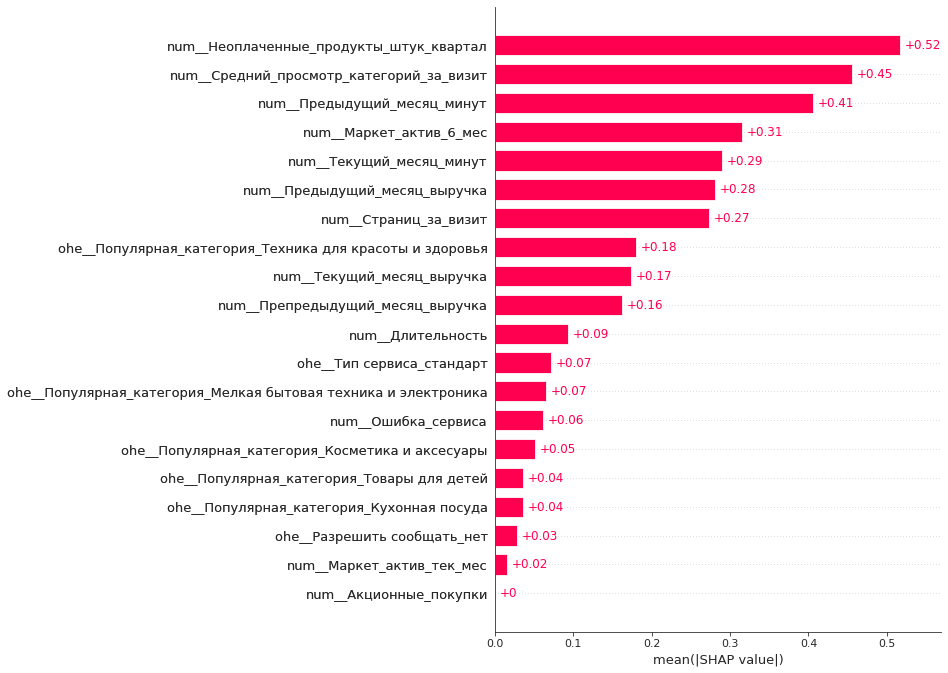

In [48]:
transformed = preprocessor.transform(segment_df)

segment_p = pd.DataFrame(
    transformed,
    columns=preprocessor.get_feature_names_out()
) 

explainer = shap.LinearExplainer(model, segment_p)
shap_values = explainer(transformed)
shap_values.feature_names = preprocessor.get_feature_names_out().tolist()
shap.plots.bar(shap_values, max_display=30)

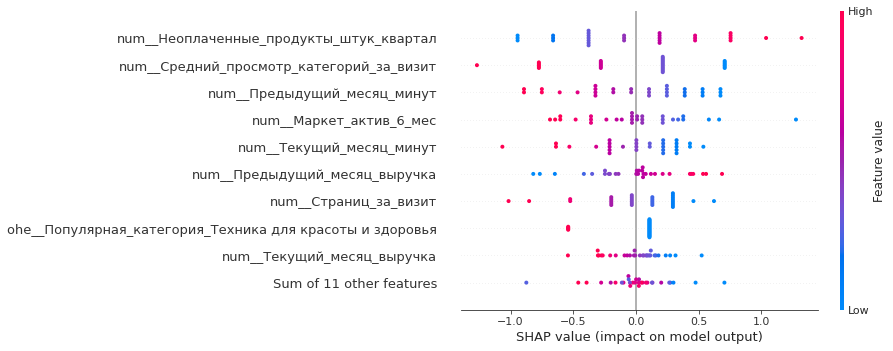

In [49]:
shap.plots.beeswarm(shap_values) 

Увеличение неоплаченных продуктов штук квартал увеличивает вероятность отнесения к классу 1 (Снижение покупательской активности) проверим через диаграмму рассеивания:

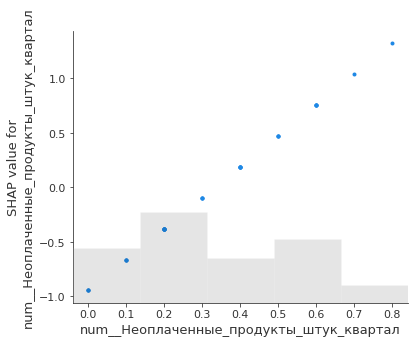

In [50]:
shap.plots.scatter(shap_values[:,"num__Неоплаченные_продукты_штук_квартал"])

Увеличение среднего просмотра за визит снижает вероятность отнесения к классу 1:

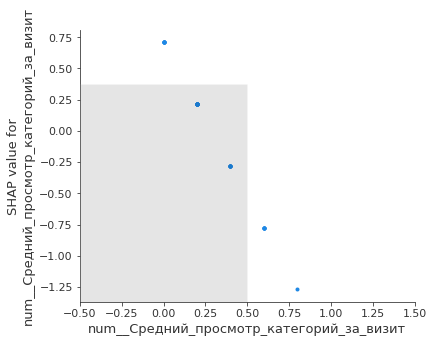

In [51]:
shap.plots.scatter(shap_values[:,"num__Средний_просмотр_категорий_за_визит"])

Увеличение значение времени, проведённого на сайте в предудущем месяце снижает вероятность отнесения к классу 1:

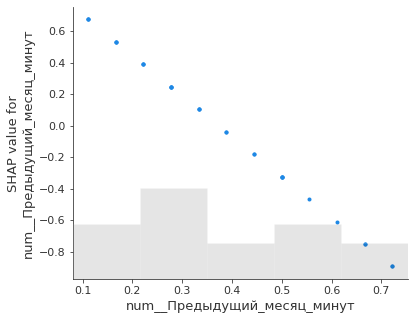

In [52]:
shap.plots.scatter(shap_values[:,"num__Предыдущий_месяц_минут"])

Увеличение среднемесячное значение маркетинговых коммуникаций компании снижает вероятность отнесения к классу 1:

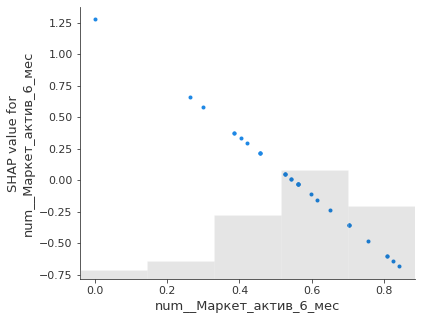

In [53]:
shap.plots.scatter(shap_values[:,"num__Маркет_актив_6_мес"])

Проверим уменьшим значение `Неоплаченные_продукты_штук_квартал`, а остальные увеличим в полученном сегменте:

In [54]:
segment_df['Неоплаченные_продукты_штук_квартал'] = 1
segment_df['Средний_просмотр_категорий_за_визит'] = 5
segment_df['Предыдущий_месяц_минут'] = 15
segment_df['Маркет_актив_6_мес'] = 7
segment_df.loc[:, 'Покупательская активность'] = randomized_search.predict(segment_df)
segment_df

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Предыдущий_месяц_выручка,Текущий_месяц_выручка,Препредыдущий_месяц_выручка,Предыдущий_месяц_минут,Текущий_месяц_минут,Покупательская активность вероятность
3,215351,Прежний уровень,стандарт,да,7,5,896,0.99,Товары для детей,5,1,6,4,6158.0,6610.4,4793.0,15,13,0.806432
40,215388,Снизилась,стандарт,да,7,4,663,0.99,Домашний текстиль,5,1,2,2,3188.0,3232.2,4182.0,15,12,0.961655
97,215445,Прежний уровень,стандарт,нет,7,5,372,0.99,Косметика и аксесуары,5,1,6,5,5186.5,5208.6,4528.0,15,10,0.993976
115,215463,Снизилась,стандарт,нет,7,4,472,0.99,Домашний текстиль,5,1,3,3,5196.0,5015.3,4470.0,15,12,0.996315
135,215483,Прежний уровень,стандарт,да,7,5,855,0.99,Кухонная посуда,5,1,7,6,6349.0,6355.5,4834.0,15,8,0.993690
137,215485,Прежний уровень,стандарт,да,7,4,720,0.99,Косметика и аксесуары,5,1,4,7,4201.0,5065.5,4234.0,15,14,0.968643
145,215493,Прежний уровень,стандарт,да,7,5,881,0.99,Кухонная посуда,5,1,6,5,6716.5,7799.4,4870.0,15,10,0.979810
189,215537,Прежний уровень,премиум,да,7,4,705,0.99,Косметика и аксесуары,5,1,7,4,6121.5,6781.9,4974.0,15,9,0.969811
217,215565,Прежний уровень,стандарт,нет,7,4,522,0.99,Кухонная посуда,5,1,4,4,4657.0,5104.2,4492.0,15,12,0.990342
225,215573,Прежний уровень,стандарт,да,7,4,706,0.99,Кухонная посуда,5,1,2,6,5418.0,5501.2,4671.0,15,12,0.982744


Количество клиентов со снижением активности уменьшилось до 4.

Для уменьшения числа неоплаченных товаров в корзине и увеличения маркетинговой активности, можно предложить уведомлять клиента о том что у него есть неоплаченные товары в корзине (или предоставлять персональную скидку на них), проверим сколько пользователей в сегменте разрешили дополнительные предложения о товаре:

<AxesSubplot:title={'center':'Разрешить сообщать'}, ylabel='Разрешить сообщать'>

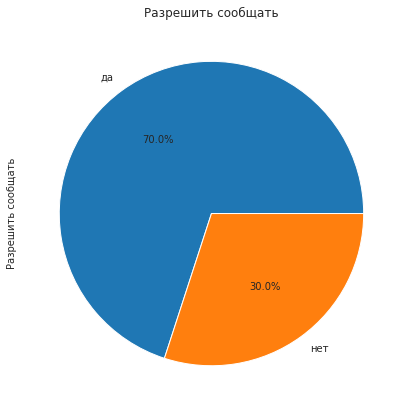

In [55]:
segment_df['Разрешить сообщать'].value_counts().plot(title='Разрешить сообщать', autopct='%1.1f%%', kind='pie', figsize=(7,7))

Большенство клиентов разрешили дополнительные предложения.

Для увеличения времени просмотра и количества просматриваемых категорий можно учитывать пользовательские предпочтения при отображении информации на сайте.

Найдем популярные категории в данном сегменте:

<AxesSubplot:title={'center':'Популярная_категория'}, ylabel='Популярная_категория'>

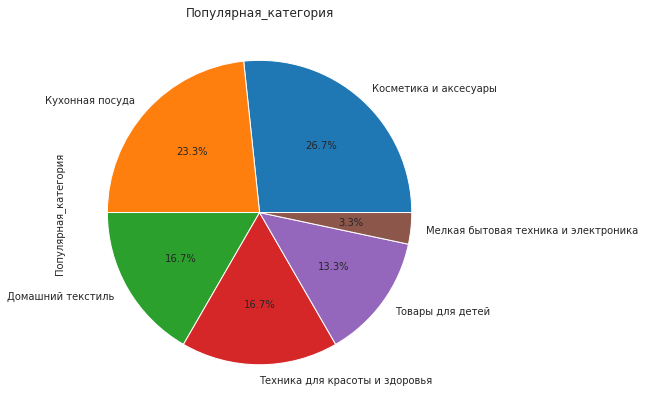

In [56]:
segment_df['Популярная_категория'].value_counts().plot(title='Популярная_категория', autopct='%1.1f%%', kind='pie', figsize=(7,7))

Наиболее популярные категории это `Косметика и аксесуары` и `Кухонная посуда`

Выделен сегмент - Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. Для него получены признаки которые наиболее влияют на уменьшение активности пользователей. Представлены рекомендации для увеличения пользовательской активности.

## Общий вывод

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

Были выполнены следующие действия:

- выполнена предобработка данных (изменены типы данных, устранены дубликаты, проверены пропуски);
- проведен исследовательский анализ данных (проверены аномалии и выбросы в данных, выделены постоянные клиенты);
- проведено объединение таблиц;
- проведен корреляционный анализ;
- найдена лучшая модель используя общий пайплайн для всех моделей и инструмент подбора гиперпараметров;
- проведен анализ важности признаков;
- выделен сегмент и проведен анализ, сделаны предложения для увеличения покупательской активности.

В общем для всех клиентов было получено:
Признаки сильнее всего влияющие на снижение покупательской активности:
- Средний просмотр категорий за визит
- Страниц за визит
- Аукционные покупки
- Предыдущий месяц минут
- Неоплаченные продукты штук квартал
- Текущий месяц минут
- Маркет актив 6 мес
- Популярная категория Мелкая бытовая техника и электроника
- Предыдущий месяц выручка
- Препредыдущий месяц выручка
- Популярная категория Техника для красоты и здоровья
- Текущий месяц выручка

Мало значимые признаки:
- Маркет актив тек мес
- Популярный категория Кухонная посуда
- Разрешить сообщать нет
- Популярная категория Косметика и аксесуары
- Популярная категория Товары для детей
- Ошибка сервиса
- Тип сервиса стандарт
- Длительность

Был выделен сегмент - группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. Для него получены рекомендации по увеличению покупательской активности:
- снижение неоплаченных продуктов штук квартал уменьшает вероятность снижения покупательской активности;
- увеличение среднего просмотра за визит снижает вероятность снижения покупательской активности;
- увеличение значение времени, проведённого на сайте в предыдущем месяце снижает вероятность снижения покупательской активности;
- увеличение среднемесячного значения маркетинговых коммуникаций компании снижает вероятность снижения покупательской активности.

Для уменьшения числа неоплаченных товаров в корзине и увеличения маркетинговой активности, можно предложить уведомлять клиента о том что у него есть неоплаченные товары в корзине (или предоставлять персональную скидку на них).

Для увеличения времени просмотра и количества просматриваемых категорий можно учитывать пользовательские предпочтения при отображении информации на сайте.